In [ ]:
# 1. 나눔 폰트 설치 명령어
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 2. 런타임 재시작 (이 메시지를 본 후 직접 실행)
print("❌ 폰트 변경을 위해 [런타임] -> [런타임 다시 시작]을 클릭하세요. 재시작 후 다음 코드 블록을 실행하세요.")

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/

# 데이터불러오기

In [ ]:
''' 데이터불러오기'''

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import os

# ==============================================================================
# 0. 환경 설정 및 파일 로드 (Google Drive 경로)
# ==============================================================================
DRIVE_PATH = '/content/drive/MyDrive/bigcon/data/raw/'
FILE_1_MASTER = os.path.join(DRIVE_PATH, "big_data_set1_f.csv")
FILE_2_PERF = os.path.join(DRIVE_PATH, "big_data_set2_f.csv")
FILE_3_CUST = os.path.join(DRIVE_PATH, "big_data_set3_f.csv")
GEOCODED_FILE = os.path.join(DRIVE_PATH, "df_geocoded.csv")
MACRO_FILE = os.path.join(DRIVE_PATH, "macro_data_combined_final.csv")
Preprocessing=os.path.join(DRIVE_PATH,"df_Preprocessing.csv")

FILE_1_PRE=os.path.join(DRIVE_PATH,"df1_pre.csv")
FILE_23_PRE=os.path.join(DRIVE_PATH,"df23_pre.csv")
OUT_PRE=os.path.join(DRIVE_PATH,"out_pre.csv")


# MISSING_VALUE_CODE = -999999.9
# LAG_PERIOD = 3
# PREDICTION_WINDOW_MONTHS = 5
# SALES_DROP_THRESHOLD = -0.15 # 매출 급락 기준: 전월 대비 10% 하락

# 데이터 로드
try:
    df1_org = pd.read_csv(FILE_1_MASTER, encoding='cp949')
    df2_org = pd.read_csv(FILE_2_PERF, encoding='cp949')
    df3_org= pd.read_csv(FILE_3_CUST, encoding='cp949')
    df_geocoded_org = pd.read_csv(GEOCODED_FILE, encoding='utf8', index_col=0)
    combined_macro_df = pd.read_csv(MACRO_FILE, encoding='utf8')
    df_preprocessing=pd.read_csv(Preprocessing, encoding='utf8')

    df1_pre_org=pd.read_csv(FILE_1_PRE, encoding='utf8')
    df23_pre_org=pd.read_csv(FILE_23_PRE, encoding='utf8')
    out_pre_org=pd.read_csv(OUT_PRE, encoding='utf8')

except Exception as e:
    raise RuntimeError(f"❌ 파일 로드 실패: {e}")

# data copy 생성
df1=df1_org.copy()
df2=df2_org.copy()
df3=df3_org.copy()
out=combined_macro_df.copy()
df=df_preprocessing.copy()
df_geocoded = df_geocoded_org.copy()

df1_pre=df1_pre_org.copy()
df23_pre=df23_pre_org.copy()
out_pre=out_pre_org.copy()

🚀 빅콘테스트 AI 조기 경보 시스템 모델링 파이프라인
1단계: 데이터 통합 및 Y 변수 정의 (Target Definition)
먼저 모든 데이터를 하나의 분석용 데이터셋으로 합쳐야 합니다. 이 단계의 최종 목표는 가맹점 1곳당 1개의 행을 갖는 데이터셋을 만드는 것입니다.

외부 데이터 결합: df23_pre.csv (가맹점 월별 데이터)와 out_pre.csv (외부 거시경제 데이터)를 **기준년월**을 기준으로 병합합니다.

기본 정보 결합: 위에서 합친 월별 데이터를 df1_pre.csv (가맹점 기본 정보)와 **가맹점구분번호**를 기준으로 병합합니다.

Y 변수 (Target) 정의:

Target (Y): df1_pre 파일에 있는 폐업여부 컬럼을 사용합니다. (이 컬럼이 '25.7월 이후 폐업 여부를 나타내는 0/1 값이라고 가정합니다.)

Features (X): Y 변수를 제외한 나머지 모든 컬럼이 X의 재료가 됩니다.

2단계: 피처 엔지니어링 (Feature Engineering)
가장 중요한 단계입니다. '23.1~'24.12 (24개월) 동안의 시계열 데이터를 **가맹점구분번호**별로 집계(Aggregate)하여, 각 가맹점의 '24년 12월 말' 기준 상태와 트렌드를 나타내는 피처들을 생성합니다.

A. 정적 피처 (Static Features)
df1_pre에서 가져오는, 시간이 지나도 변하지 않는 정보입니다.

카테고리형: 업종, 상권, 가맹점주소 (e.g., '성동구' 등). -> 후보: 원-핫 인코딩 또는 타겟 인코딩

수치형: LAT, LNG (위도/경도), 브랜드구분코드_FREQ (브랜드 빈도)

B. 동적 피처 (Dynamic Features - Aggregation)
df23_pre (월별 데이터)를 가맹점별로 집계하여 생성합니다.

최근 상태 (Recent Status): '24년 12월' (가장 마지막 달)의 주요 값들

최근_매출순위비율: 동일 업종 내 매출 순위 비율 (24년 12월 값)

최근_재방문고객비중: 재방문 고객 비중 (24년 12월 값)

최근_신규고객비중: 신규 고객 비중 (24년 12월 값)

기간 통계 (Rolling Statistics): 24개월 전체 기간 및 최근 6개월('24.07~'24.12) 기간의 통계치

6M_매출순위_평균, 6M_매출순위_표준편차 (표준편차는 '변동성'을 의미)

24M_재방문비중_평균, 6M_재방문비중_최대값

6M_신규고객_평균, 6M_신규고객_표준편차

24M_남성20대고객비중_평균, 24M_여성30대고객비중_평균 (주요 고객층)

트렌드 (Trend): 시간에 따른 변화율 (e.g., 24개월간의 월별 데이터로 1차 선형회귀를 피팅한 후의 기울기(slope) 값)

트렌드_매출순위: 24개월간 동일 업종 내 매출 순위 비율의 변화 추세 (기울기)

트렌드_재방문비중: 24개월간 재방문 고객 비중의 변화 추세 (기울기)

참고: 이 피처는 매출이 '상승세'인지 '하락세'인지 직접적으로 보여줍니다.

C. 파생 피처 (Derived Features)
운영 기간: df1_pre의 개설일과 기준 시점('24년 12월')을 비교

총_운영개월수: 가맹점이 얼마나 오래되었는지 (신규 업체인지)

거시 경제: out_pre의 '24년 12월' 기준 거시경제 지표

최종_기준금리, 최종_소비심리지수, 최종_외식_CPI (모든 가맹점에 동일하게 적용)

3단계: 데이터 검증 전략 (Validation Strategy)
말씀하신 대로 데이터 불균형이 심각하므로, 이 부분이 매우 중요합니다.

문제: 우리는 X (23-24년 데이터)와 Y (25년 7월 이후 폐업 여부)로 구성된 Cross-sectional (횡단면) 데이터를 만들었습니다. 따라서 시계열 분할이 아닌, 참조하신 이미지처럼 불균형을 고려한 분할을 사용해야 합니다.

전략: 계층화된 K-Fold 교차 검증 (Stratified K-Fold Cross-Validation)

Train / Test 분리:

먼저 전체 데이터(X, Y)를 train_test_split을 사용해 훈련+검증 세트 (80%)와 최종 테스트 세트 (20%)로 분리합니다.

핵심: stratify=y 옵션을 반드시 사용해야 합니다.

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_test, y_test는 모델 최종 평가에만 1번 사용하고 절대 훈련 과정에 개입시키지 않습니다.

K-Fold 교차 검증 (on X_train_val):

StratifiedKFold(n_splits=5, shuffle=True, random_state=42)를 사용합니다.

X_train_val을 5개의 Fold로 나누되, 각 Fold마다 Y=1 (폐업) 비율이 원본과 동일하게 유지됩니다.

5번의 검증을 통해 모델 성능의 평균과 표준편차를 확인하여 안정성을 평가합니다.

4단계: 불균형 데이터 처리 (Imbalance Handling)
SMOTE와 같은 오버샘플링 기법은 데이터 누수(Leakage) 방지가 핵심입니다.

잘못된 방법: X_train_val 전체에 SMOTE를 적용한 뒤 K-Fold를 돌리는 것. (검증 Fold에 이미 가상의 데이터가 섞여 들어가 성능이 부풀려짐)

올바른 방법: K-Fold 루프 안에서 적용

imbalanced-learn 라이브러리의 **Pipeline**을 사용하는 것이 가장 좋습니다.

Pipeline은 훈련용 Fold 데이터에 대해서만 **SMOTE를 적용(fit_sample)**하고, 검증용 Fold 데이터는 원본 그대로 **예측(predict)**합니다.5단계: 모델링 및 Feature Importance
속도를 중시하고, Feature Importance를 얻을 수 있는 모델 3가지를 사용합니다. 파라미터는 속도를 위해 최소한으로 설정합니다.

Logistic Regression (로지스틱 회귀)

특징: 기본 베이스라인, 속도가 빠름, 피처의 방향성(+/-) 해석 용이.

파라미터 (속도): solver='liblinear'

중요도: model.coef_ (각 피처의 계수)

Random Forest (랜덤 포레스트)

특징: 안정적인 성능, Feature Importance 제공.

파라미터 (속도): n_estimators=100 (트리 개수 줄이기), max_depth=5 (트리 깊이 제한), n_jobs=-1 (모든 CPU 코어 사용)

중요도: model.feature_importances_ (Gini importance)

LightGBM (LGBM)

특징: 대용량 데이터에서 가장 빠르고 성능이 좋은 트리 기반 부스팅 모델.

파라미터 (속도): n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1

중요도: model.feature_importances_ (Split/Gain importance)

6단계: 평가 (Evaluation)
불균형 데이터이므로 **정확도(Accuracy)**는 절대 사용하면 안 됩니다.

핵심 지표:

ROC-AUC: 모델의 전반적인 판별 성능 (1에 가까울수록 좋음)

Precision (정밀도): 모델이 '폐업'이라고 예측한 것 중 실제 '폐업'인 비율 (경보의 신뢰성)

Recall (재현율): 실제 '폐업'한 가맹점 중 모델이 '폐업'이라고 맞춘 비율 (경보 시스템이 얼마나 많이 잡아내는가)

F1-Score: Precision과 Recall의 조화 평균

In [ ]:

# ==============================================================================
# 🚀 1단계: 분석 기반 데이터 생성 (Analysis Base Table)
# ==============================================================================
print("--- 1단계: 분석 기반 데이터 생성 시작 ---")

# --- 날짜 형식 변환 ---
df1_pre['개설일'] = pd.to_datetime(df1_pre['개설일'], errors='coerce')
df1_pre['폐업일'] = pd.to_datetime(df1_pre['폐업일'], errors='coerce')

# --- 분석 대상 선정 ---
# 1. 23년, 24년에 '이미' 폐업한 가맹점은 분석에서 제외
df_base = df1_pre[~(df1_pre['폐업일'] < '2025-01-01')].copy()

# 2. Y 변수 (TARGET) 생성
df_base['TARGET'] = df_base['폐업일'].notna().astype(int)

print(f"분석 대상 가맹점 수: {len(df_base)}개")
print("Y값 (TARGET) 분포:")
print(df_base['TARGET'].value_counts())
print("------------------------------------\n")


# ==============================================================================
# 🚀 2단계: 피처 엔지니어링 (Feature Engineering)
# ==============================================================================
print("--- 2단계: 피처 엔지니어링 시작 ---")

# --- 사전 처리 (Preprocessing) ---
df23_pre['기준년월'] = pd.to_datetime(df23_pre['기준년월'])
df23_pre.replace(-999999.9, np.nan, inplace=True)
out_pre['기준년월'] = pd.to_datetime(out_pre['기준년월'], format='%Y%m')

# --- 피처 생성 준비 ---
df23_merged = pd.merge(df23_pre, out_pre, on='기준년월', how='left')
df_features = pd.DataFrame({'가맹점구분번호': df_base['가맹점구분번호'].unique()})


# --- A. 정적 피처 (Static Features) ---
print("  A. 정적 피처 생성 중...")
df_features = pd.merge(df_features,
                       df_base[['가맹점구분번호', '업종', '상권', '개설일']],
                       on='가맹점구분번호', how='left')

base_date = pd.to_datetime('2024-12-31')
df_features['총_운영개월수'] = df_features['개설일'].apply(
    lambda x: relativedelta(base_date, x).years * 12 + relativedelta(base_date, x).months
)
df_features.drop('개설일', axis=1, inplace=True)


# --- B. 동적 피처 (Dynamic Features from Aggregation) ---
print("  B. 동적 피처 (집계) 생성 중...")
agg_cols = [
    '동일 업종 내 매출 순위 비율', '동일 상권 내 매출 순위 비율',
    '재방문 고객 비중', '신규 고객 비중',
    '동일 업종 내 해지 가맹점 비중', '동일 상권 내 해지 가맹점 비중',
    '한국은행_기준금리', '소비심리지수'
]

grouped_24m = df23_merged.groupby('가맹점구분번호')[agg_cols].agg(['mean', 'std', 'min', 'max']).reset_index()
grouped_24m.columns = ['_'.join(col).strip() for col in grouped_24m.columns.values]
grouped_24m.rename(columns={'가맹점구분번호_': '가맹점구분번호'}, inplace=True)

df23_last_6m = df23_merged[df23_merged['기준년월'] >= '2024-07-01']
grouped_6m = df23_last_6m.groupby('가맹점구분번호')[agg_cols].agg(['mean', 'std']).reset_index()
grouped_6m.columns = ['6M_' + '_'.join(col).strip() for col in grouped_6m.columns.values]
grouped_6m.rename(columns={'6M_가맹점구분번호_': '가맹점구분번호'}, inplace=True)

df23_last_month = df23_merged[df23_merged['기준년월'] == '2024-12-01']
last_month_features = df23_last_month[['가맹점구분번호'] + agg_cols]
last_month_features.columns = ['가맹점구분번호'] + ['최근_' + col for col in agg_cols]

df_features = pd.merge(df_features, grouped_24m, on='가맹점구분번호', how='left')
df_features = pd.merge(df_features, grouped_6m, on='가맹점구분번호', how='left')
df_features = pd.merge(df_features, last_month_features, on='가맹점구분번호', how='left')


# --- C. 트렌드 피처 (Trend Features) ---
print("  C. 트렌드 피처 생성 중... (시간이 다소 소요될 수 있습니다)")

def calculate_slope_robust(series):
    valid_series = series.dropna()
    if len(valid_series) < 2:
        return np.nan
    y = valid_series.values
    x = np.arange(len(y))
    try:
        slope, _ = np.polyfit(x, y, 1)
        return slope
    except LinAlgError:
        return np.nan

trend_cols = ['동일 업종 내 매출 순위 비율', '재방문 고객 비중']
trends_24m = df23_merged.groupby('가맹점구분번호')[trend_cols].apply(
    lambda g: g.apply(calculate_slope_robust)
).reset_index()
trends_24m.columns = ['가맹점구분번호'] + ['24M_트렌드_' + col for col in trend_cols]

trends_6m = df23_last_6m.groupby('가맹점구분번호')[trend_cols].apply(
    lambda g: g.apply(calculate_slope_robust)
).reset_index()
trends_6m.columns = ['가맹점구분번호'] + ['6M_트렌드_' + col for col in trend_cols]

df_features = pd.merge(df_features, trends_24m, on='가맹점구분번호', how='left')
df_features = pd.merge(df_features, trends_6m, on='가맹점구분번호', how='left')
print("------------------------------------\n")


# ==============================================================================
# 🚀 3단계: 최종 데이터셋 결합 및 정리
# ==============================================================================
print("--- 3단계: 최종 데이터셋 생성 시작 ---")

df_final = pd.merge(df_base[['가맹점구분번호', 'TARGET']], df_features, on='가맹점구분번호', how='left')
df_final.fillna(0, inplace=True)
df_final = pd.get_dummies(df_final, columns=['업종', '상권'], dummy_na=False)

print(f"✅ 최종 데이터셋 생성 완료! Shape: {df_final.shape}")
print("--- 최종 데이터셋 상위 5개 행 ---")
print(df_final.head())
print("------------------------------------\n")


--- 1단계: 분석 기반 데이터 생성 시작 ---
분석 대상 가맹점 수: 4155개
Y값 (TARGET) 분포:
TARGET
0    4058
1      97
Name: count, dtype: int64
------------------------------------

--- 2단계: 피처 엔지니어링 시작 ---
  A. 정적 피처 생성 중...
  B. 동적 피처 (집계) 생성 중...
  C. 트렌드 피처 생성 중... (시간이 다소 소요될 수 있습니다)
------------------------------------

--- 3단계: 최종 데이터셋 생성 시작 ---
✅ 최종 데이터셋 생성 완료! Shape: (4155, 158)
--- 최종 데이터셋 상위 5개 행 ---
      가맹점구분번호  TARGET  총_운영개월수  동일 업종 내 매출 순위 비율_mean  동일 업종 내 매출 순위 비율_std  \
0  16184E93D9       0      141              20.758333              8.133341   
1  4D039EA8B7       0      133              17.737500              3.539935   
2  0074C4990A       0      127               9.754167              5.504621   
3  68308F2746       0      109              63.425000             19.417949   
4  4117EDDE9C       0      108              92.916667             10.306295   

   동일 업종 내 매출 순위 비율_min  동일 업종 내 매출 순위 비율_max  동일 상권 내 매출 순위 비율_mean  \
0                  11.0                  28.8              21.304

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


--- 4단계: 머신러닝 모델링 및 평가 시작 ---

--- 교차 검증을 통한 모델 훈련 및 평가 ---
  - LogisticRegression 모델 훈련 중...


/tmp/ipython-input-1479318530.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


  - LinearSVC 모델 훈련 중...
  - RandomForest 모델 훈련 중...
  - LGBM 모델 훈련 중...
  - XGBoost 모델 훈련 중...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:58:59] WARNING: /w

  - CatBoost 모델 훈련 중...

--- 모델별 평균 성능 요약 ---
                     ROC_AUC  Precision    Recall  F1_Score
Model                                                      
RandomForest        0.524742   0.020677  0.082632  0.032534
LGBM                0.515348   0.033333  0.010000  0.015385
CatBoost            0.505077   0.000000  0.000000  0.000000
XGBoost             0.489702   0.040000  0.010000  0.016000
LogisticRegression  0.424272   0.017060  0.217368  0.031636
LinearSVC           0.418645   0.015061  0.062105  0.024233
------------------------------------

--- 5단계: 피처 중요도 시각화 시작 ---
  - LogisticRegression 피처 중요도 생성 중...


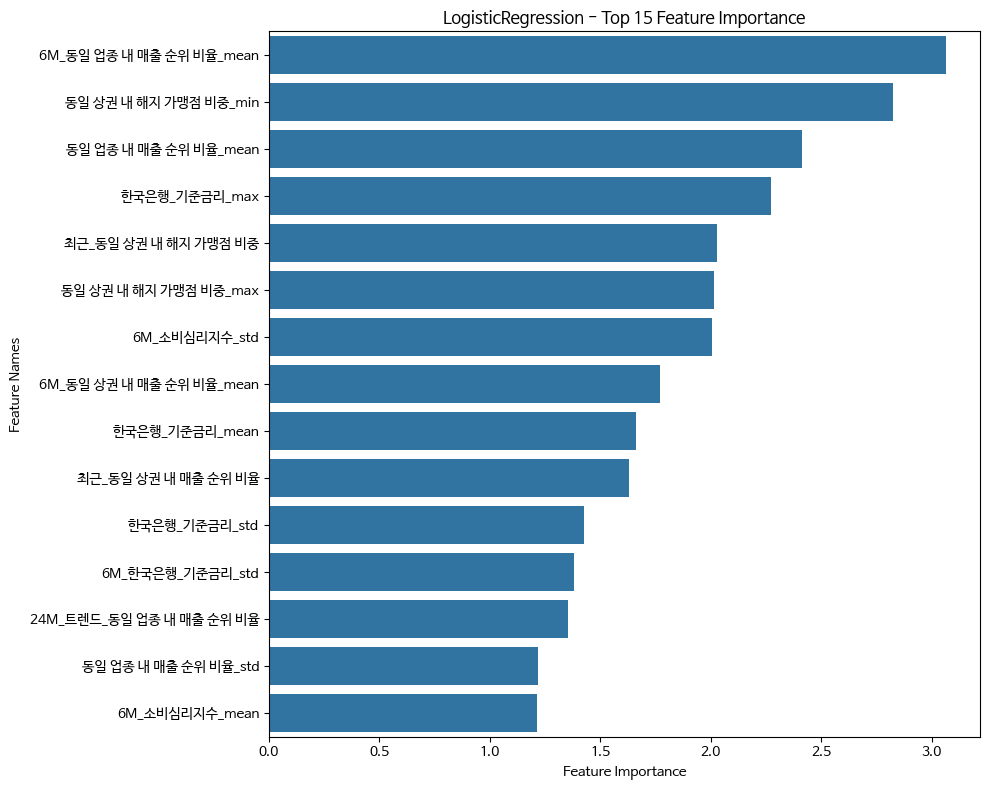

  - LinearSVC 피처 중요도 생성 중...


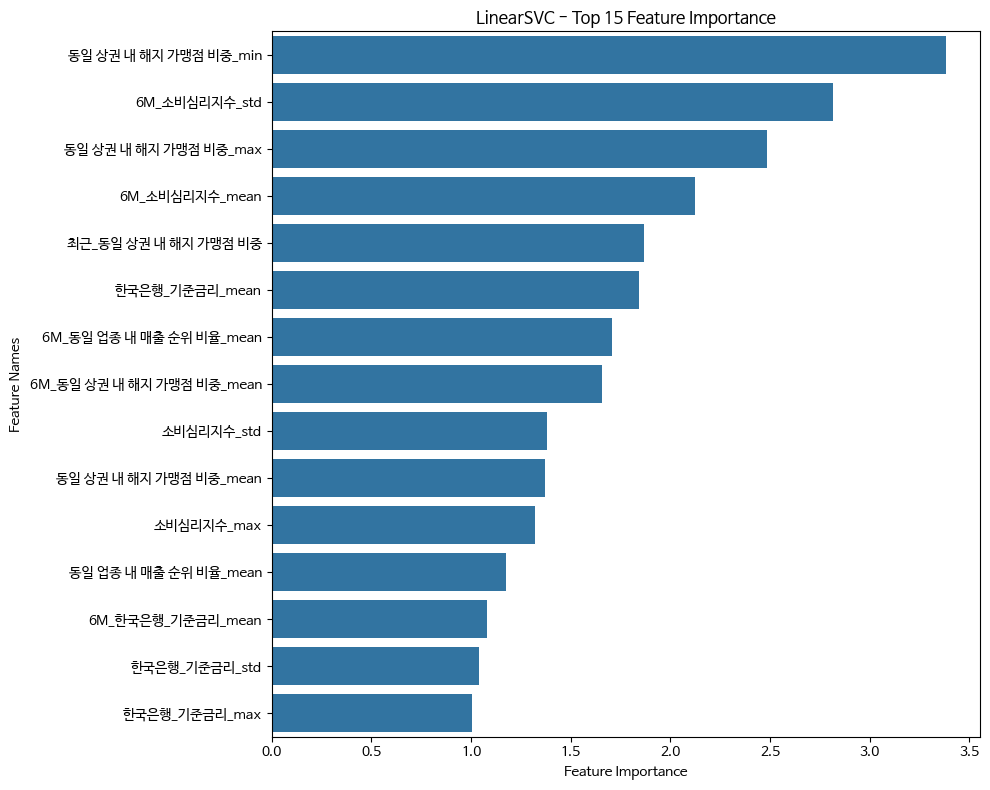

  - RandomForest 피처 중요도 생성 중...


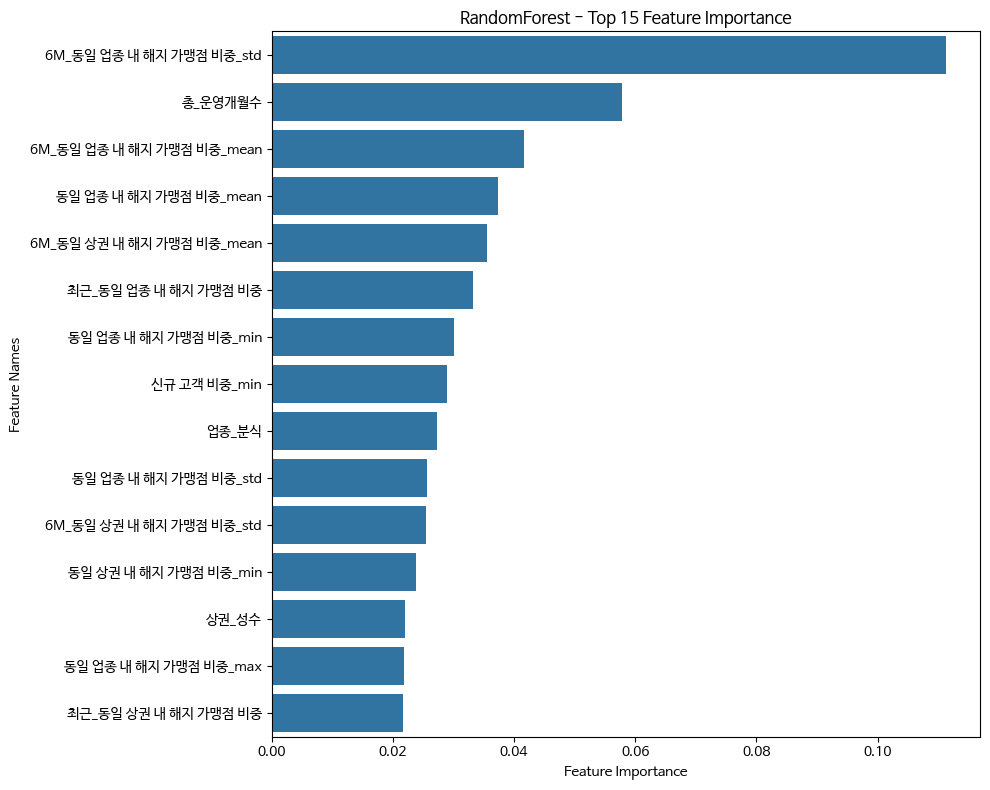

  - LGBM 피처 중요도 생성 중...


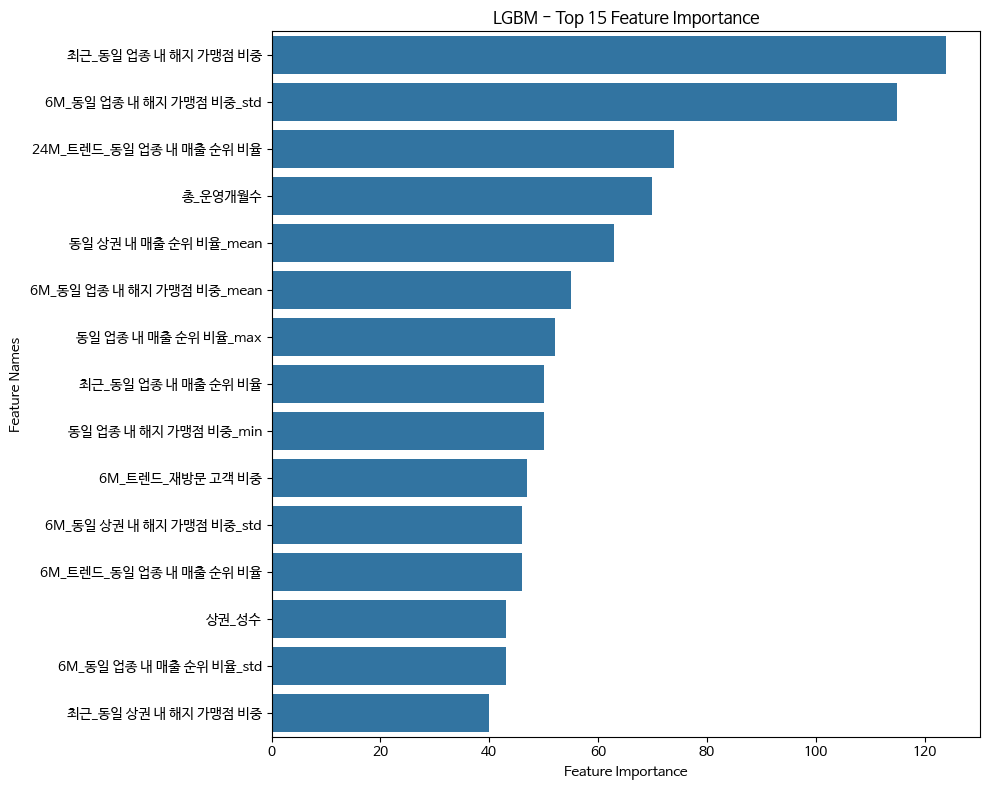

  - XGBoost 피처 중요도 생성 중...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:59:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


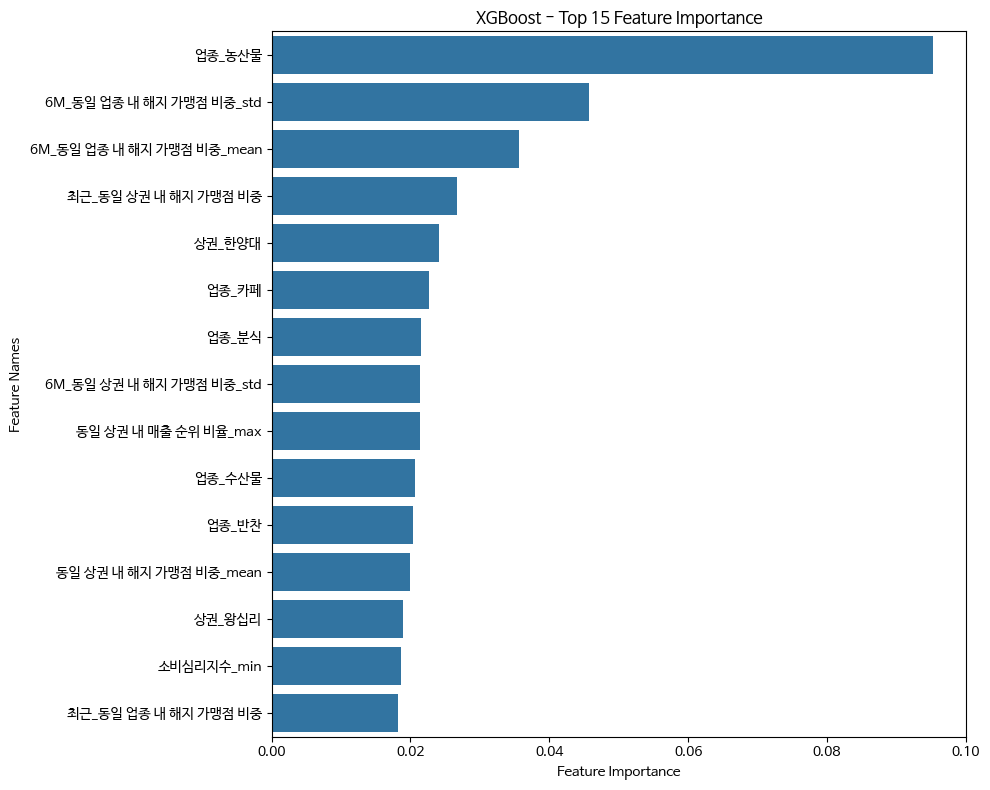

  - CatBoost 피처 중요도 생성 중...


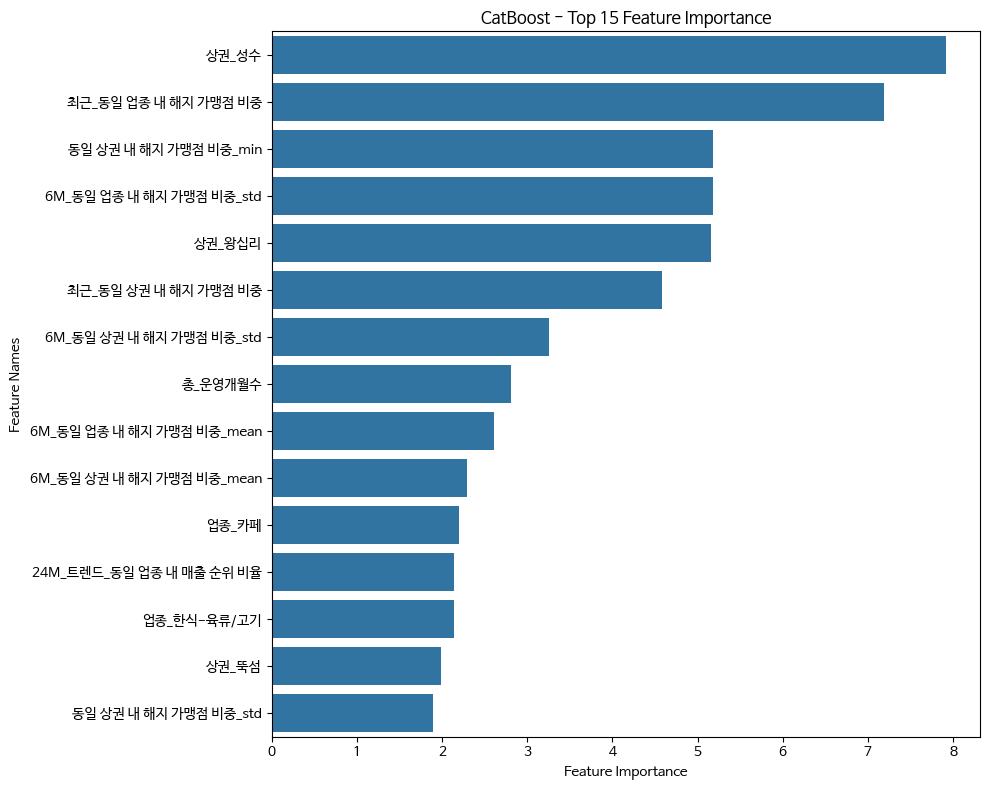

--- 모든 작업 완료 ---


In [ ]:
# ==============================================================================
# 🚀 4단계: 머신러닝 모델링 및 평가
# ==============================================================================
print("--- 4단계: 머신러닝 모델링 및 평가 시작 ---")

# --- 라이브러리 임포트 ---
# 모델링
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 불균형 처리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # sklearn Pipeline과 이름 충돌 방지

# 평가
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
try:
    plt.rc('font', family='NanumBarunGothic')
except:
    print("나눔바른고딕 폰트가 설치되어 있지 않아, 기본 폰트로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False


# --- 데이터 준비 ---
# 1. 피처(X)와 타겟(y) 분리
X = df_final.drop(columns=['가맹점구분번호', 'TARGET'])
y = df_final['TARGET']

# 2. 데이터 스케일링 (선형 모델 및 SVC에 필요)
#    StandardScaler를 사용해 데이터를 표준화합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- 모델 정의 ---
# 속도를 고려한 파라미터로 6개 모델을 설정합니다.
models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
    'LinearSVC': LinearSVC(max_iter=2000, random_state=42), # 반복 횟수 증가
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'LGBM': LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbosity=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, depth=5, random_state=42, verbose=0)
}

# --- 교차 검증 설정 ---
# 5-Fold 계층화 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과를 저장할 데이터프레임
results_df = pd.DataFrame(columns=['Model', 'Fold', 'ROC_AUC', 'Precision', 'Recall', 'F1_Score'])

# --- 모델 훈련 및 평가 루프 ---
print("\n--- 교차 검증을 통한 모델 훈련 및 평가 ---")
for model_name, model in models.items():
    print(f"  - {model_name} 모델 훈련 중...")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # 1. 데이터 분리
        #    선형 모델/SVC는 스케일된 데이터를, 트리 모델은 원본 데이터를 사용합니다.
        if model_name in ['LogisticRegression', 'LinearSVC']:
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        else:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 2. SMOTE 오버샘플링 (훈련 데이터에만 적용!)
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # 3. 모델 훈련
        model.fit(X_train_res, y_train_res)

        # 4. 예측
        y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_val)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # 5. 평가
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        # 6. 결과 저장
        new_row = pd.DataFrame({
            'Model': [model_name], 'Fold': [fold+1], 'ROC_AUC': [roc_auc],
            'Precision': [precision], 'Recall': [recall], 'F1_Score': [f1]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# --- 최종 성능 요약 ---
print("\n--- 모델별 평균 성능 요약 ---")
final_summary = results_df.groupby('Model')[['ROC_AUC', 'Precision', 'Recall', 'F1_Score']].mean().sort_values(by='ROC_AUC', ascending=False)
print(final_summary)
print("------------------------------------\n")


# ==============================================================================
# 🚀 5단계: 피처 중요도 시각화
# ==============================================================================
print("--- 5단계: 피처 중요도 시각화 시작 ---")

# --- 피처 중요도를 그리는 함수 ---
def plot_feature_importance(importance, names, model_name):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    top_fi = fi_df.head(15) # 상위 15개만 시각화

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_fi['feature_importance'], y=top_fi['feature_names'])
    plt.title(f'{model_name} - Top 15 Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.tight_layout()
    plt.show()

# --- 전체 데이터로 모델 재훈련 및 피처 중요도 추출 ---
# SMOTE를 전체 데이터에 적용하여 안정적인 피처 중요도를 얻습니다.
smote_all = SMOTE(random_state=42)
X_res_all, y_res_all = smote_all.fit_resample(X, y)
X_scaled_res_all, _ = smote_all.fit_resample(X_scaled, y) # 스케일된 데이터도 동일하게

for model_name, model in models.items():
    print(f"  - {model_name} 피처 중요도 생성 중...")
    if model_name in ['LogisticRegression', 'LinearSVC']:
        model.fit(X_scaled_res_all, y_res_all)
        # 선형 모델의 계수(coef) 절대값을 중요도로 사용
        plot_feature_importance(np.abs(model.coef_[0]), X.columns, model_name)
    else:
        model.fit(X_res_all, y_res_all)
        plot_feature_importance(model.feature_importances_, X.columns, model_name)

print("--- 모든 작업 완료 ---")


수정된 모델

--- 1단계: 분석 기반 데이터 생성 시작 ---
분석 대상 가맹점 수: 4155개
------------------------------------

--- 2단계: 강화된 피처 엔지니어링 시작 ---
  A. 정적 피처 생성 중...
  B. 기본 동적 피처 (집계) 생성 중...
  C. 새로운 위기 신호 피처 생성 중...
------------------------------------

--- 3단계: 최종 데이터셋 생성 시작 ---
✅ 최종 데이터셋 생성 완료! Shape: (4155, 117)
------------------------------------

--- 4단계: 강화된 모델링 및 평가 시작 ---

--- 교차 검증을 통한 모델 훈련 및 평가 ---
  - Sampler: SMOTE, Model: LogisticRegression 훈련 중...
  - Sampler: SMOTE, Model: RandomForest 훈련 중...
  - Sampler: SMOTE, Model: LGBM 훈련 중...
  - Sampler: ADASYN, Model: LogisticRegression 훈련 중...
  - Sampler: ADASYN, Model: RandomForest 훈련 중...
  - Sampler: ADASYN, Model: LGBM 훈련 중...

--- [UPGRADE] 샘플러/모델별 평균 성능 요약 ---
                             ROC_AUC  Precision    Recall  F1_Score
Sampler Model                                                      
SMOTE   LGBM                0.531761   0.040000  0.010526  0.016667
ADASYN  LGBM                0.521940   0.053333  0.021053  0.029793
SMOTE   RandomForest

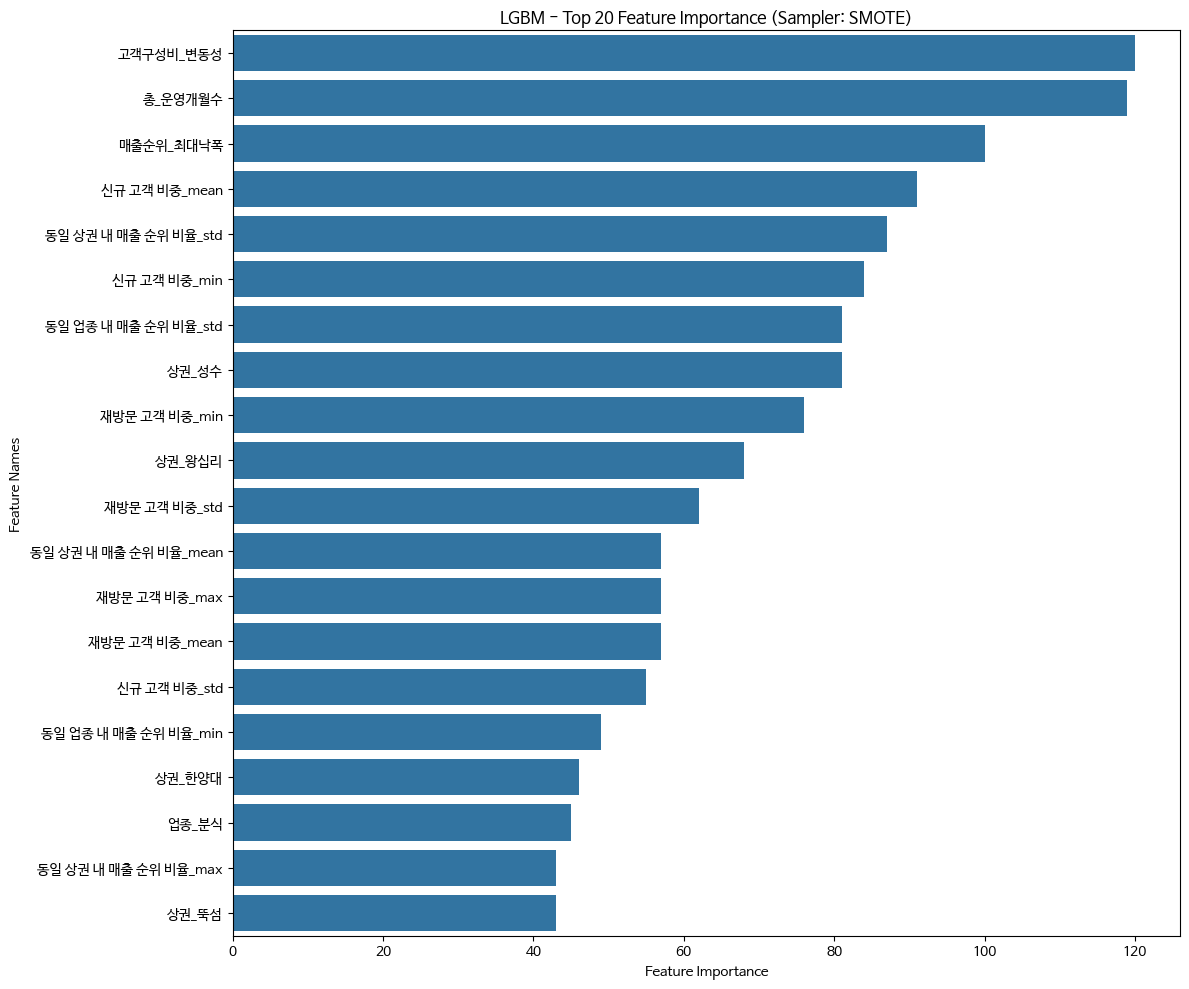

--- 모든 작업 완료 ---


In [ ]:
# ==============================================================================
# 🚀 0단계: 라이브러리 임포트 및 데이터 로드
# ==============================================================================
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from numpy.linalg import LinAlgError
import os
import warnings
warnings.filterwarnings('ignore')

# 모델링 및 평가 도구
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# 불균형 처리 도구
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# 시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
try:
    plt.rc('font', family='NanumBarunGothic')
except:
    print("나눔바른고딕 폰트가 설치되어 있지 않아, 기본 폰트로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False


# # --- 데이터 로드 ---
# try:
#     df1_pre_org = pd.read_csv("df1_pre.csv")
#     df23_pre_org = pd.read_csv("df23_pre.csv")
#     out_pre_org = pd.read_csv("out_pre.csv")
#     print("✅ 데이터 로드 성공!")
# except Exception as e:
#     raise RuntimeError(f"❌ 파일 로드 실패: {e}")

# df1_pre = df1_pre_org.copy()
# df23_pre = df23_pre_org.copy()
# out_pre = out_pre_org.copy()
# print("------------------------------------\n")


# ==============================================================================
# 🚀 1단계: 분석 기반 데이터 생성 (이전과 동일)
# ==============================================================================
print("--- 1단계: 분석 기반 데이터 생성 시작 ---")
df1_pre['개설일'] = pd.to_datetime(df1_pre['개설일'], errors='coerce')
df1_pre['폐업일'] = pd.to_datetime(df1_pre['폐업일'], errors='coerce')
df_base = df1_pre[~(df1_pre['폐업일'] < '2025-01-01')].copy()
df_base['TARGET'] = df_base['폐업일'].notna().astype(int)
print(f"분석 대상 가맹점 수: {len(df_base)}개")
print("------------------------------------\n")


# ==============================================================================
# 🚀 2단계: 🔥[UPGRADE]🔥 강화된 피처 엔지니어링
# ==============================================================================
print("--- 2단계: 강화된 피처 엔지니어링 시작 ---")
df23_pre['기준년월'] = pd.to_datetime(df23_pre['기준년월'])
df23_pre.replace(-999999.9, np.nan, inplace=True)
out_pre['기준년월'] = pd.to_datetime(out_pre['기준년월'], format='%Y%m')
df23_merged = pd.merge(df23_pre, out_pre, on='기준년월', how='left')
df_features = pd.DataFrame({'가맹점구분번호': df_base['가맹점구분번호'].unique()})

# --- A. 정적 피처 (기존과 유사) ---
print("  A. 정적 피처 생성 중...")
df_features = pd.merge(df_features, df_base[['가맹점구분번호', '업종', '상권', '개설일']], on='가맹점구분번호', how='left')
base_date = pd.to_datetime('2024-12-31')
df_features['총_운영개월수'] = df_features['개설일'].apply(
    lambda x: relativedelta(base_date, x).years * 12 + relativedelta(base_date, x).months
)
df_features.drop('개설일', axis=1, inplace=True)

# --- B. 기본 동적 피처 (기존과 유사) ---
print("  B. 기본 동적 피처 (집계) 생성 중...")
agg_cols = [
    '동일 업종 내 매출 순위 비율', '동일 상권 내 매출 순위 비율', '재방문 고객 비중', '신규 고객 비중'
]
grouped_24m = df23_merged.groupby('가맹점구분번호')[agg_cols].agg(['mean', 'std', 'min', 'max']).reset_index()
grouped_24m.columns = ['_'.join(col).strip() for col in grouped_24m.columns.values]
grouped_24m.rename(columns={'가맹점구분번호_': '가맹점구분번호'}, inplace=True)
df_features = pd.merge(df_features, grouped_24m, on='가맹점구분번호', how='left')

# --- C. 🔥[NEW]🔥 강화된 위기 신호 피처 ---
print("  C. 새로운 위기 신호 피처 생성 중...")
# 1. "충격" 피처: 매출 순위 최대 낙폭
df23_merged['매출순위_변화량'] = df23_merged.groupby('가맹점구분번호')['동일 업종 내 매출 순위 비율'].diff()
shock_features = df23_merged.groupby('가맹점구분번호')['매출순위_변화량'].max().reset_index()
shock_features.rename(columns={'매출순위_변화량': '매출순위_최대낙폭'}, inplace=True)
df_features = pd.merge(df_features, shock_features, on='가맹점구분번호', how='left')

# 2. "지속성" 피처: 하위권에 머무른 개월 수
df23_merged['하위권_여부'] = (df23_merged['동일 업종 내 매출 순위 비율'] > 80).astype(int)
persistence_features = df23_merged.groupby('가맹점구분번호')['하위권_여부'].sum().reset_index()
persistence_features.rename(columns={'하위권_여부': '매출순위_하위권_개월수'}, inplace=True)
df_features = pd.merge(df_features, persistence_features, on='가맹점구분번호', how='left')

# 3. "불안정성" 피처: 고객 구성비의 변동성
df23_merged['재방문_신규_비율'] = df23_merged['재방문 고객 비중'] / (df23_merged['신규 고객 비중'] + 0.01)
instability_features = df23_merged.groupby('가맹점구분번호')['재방문_신규_비율'].std().reset_index()
instability_features.rename(columns={'재방문_신규_비율': '고객구성비_변동성'}, inplace=True)
df_features = pd.merge(df_features, instability_features, on='가맹점구분번호', how='left')
print("------------------------------------\n")

# ==============================================================================
# 🚀 3단계: 최종 데이터셋 결합 및 정리
# ==============================================================================
print("--- 3단계: 최종 데이터셋 생성 시작 ---")
df_final = pd.merge(df_base[['가맹점구분번호', 'TARGET']], df_features, on='가맹점구분번호', how='left')
df_final.fillna(0, inplace=True)
df_final = pd.get_dummies(df_final, columns=['업종', '상권'], dummy_na=False)
print(f"✅ 최종 데이터셋 생성 완료! Shape: {df_final.shape}")
print("------------------------------------\n")


# ==============================================================================
# 🚀 4단계: 🔥[UPGRADE]🔥 강화된 모델링 및 평가
# ==============================================================================
print("--- 4단계: 강화된 모델링 및 평가 시작 ---")
X = df_final.drop(columns=['가맹점구분번호', 'TARGET'])
y = df_final['TARGET']

# --- 모델 및 샘플러 정의 ---
models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, class_weight='balanced'),
    'LGBM': LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, class_weight='balanced', verbosity=-1)
}
samplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_df = pd.DataFrame()

# --- 교차 검증 루프 ---
print("\n--- 교차 검증을 통한 모델 훈련 및 평가 ---")
for sampler_name, sampler in samplers.items():
    for model_name, model in models.items():
        print(f"  - Sampler: {sampler_name}, Model: {model_name} 훈련 중...")

        # 파이프라인 구성: 스케일러(필요시) -> 샘플러 -> 모델
        if model_name in ['LogisticRegression']:
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('sampler', sampler),
                ('model', model)
            ])
        else:
             pipeline = ImbPipeline([
                ('sampler', sampler),
                ('model', model)
            ])

        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipeline.fit(X_train, y_train)
            y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
            y_pred = (y_pred_proba > 0.5).astype(int)

            # 평가 및 결과 저장
            new_row = pd.DataFrame({
                'Sampler': [sampler_name], 'Model': [model_name], 'Fold': [fold+1],
                'ROC_AUC': [roc_auc_score(y_val, y_pred_proba)],
                'Precision': [precision_score(y_val, y_pred)],
                'Recall': [recall_score(y_val, y_pred)],
                'F1_Score': [f1_score(y_val, y_pred)]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)

# --- 최종 성능 요약 ---
print("\n--- [UPGRADE] 샘플러/모델별 평균 성능 요약 ---")
final_summary = results_df.groupby(['Sampler', 'Model'])[['ROC_AUC', 'Precision', 'Recall', 'F1_Score']].mean().sort_values(by='ROC_AUC', ascending=False)
print(final_summary)
print("------------------------------------\n")


# ==============================================================================
# 🚀 5단계: 피처 중요도 시각화 (오류 수정)
# ==============================================================================
print("--- 5단계: 피처 중요도 시각화 시작 ---")
# 가장 성능이 좋았던 조합으로 피처 중요도 확인
best_combo = final_summary.index[0]
best_sampler = samplers[best_combo[0]]
# best_model은 Pipeline이 아닌 원본 모델 객체를 가져오도록 수정
best_model_object = models[best_combo[1]]

print(f"🏆 Best Combination: Sampler='{best_combo[0]}', Model='{best_combo[1]}'")

# 전체 데이터로 재훈련
X_res_all, y_res_all = best_sampler.fit_resample(X, y)

# 🔥[FIX]🔥 모델 이름을 직접 확인하여 스케일링 적용
if best_combo[1] in ['LogisticRegression', 'LinearSVC']:
    scaler = StandardScaler()
    X_res_all = scaler.fit_transform(X_res_all)

best_model_object.fit(X_res_all, y_res_all)

# 시각화 함수 (이전과 동일)
def plot_feature_importance(importance, names, model_name):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data).sort_values(by='feature_importance', ascending=False)
    top_fi = fi_df.head(20)

    plt.figure(figsize=(12, 10))
    sns.barplot(x=top_fi['feature_importance'], y=top_fi['feature_names'])
    plt.title(f'{model_name} - Top 20 Feature Importance (Sampler: {best_combo[0]})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.tight_layout()
    plt.show()

# 피처 중요도 추출 및 시각화
if hasattr(best_model_object, 'coef_'): # 선형 모델
    plot_feature_importance(np.abs(best_model_object.coef_[0]), X.columns, best_combo[1])
else: # 트리 기반 모델
    plot_feature_importance(best_model_object.feature_importances_, X.columns, best_combo[1])

print("--- 모든 작업 완료 ---")



# 다른 Y 값

🚀 [NEW] 새로운 전략: 시계열 위기 신호 탐지 모델
우리의 목표를 "폐업 예측"에서 "매출 급락과 같은 명백한 위기 신호를 3개월 먼저 예측"하는 것으로 바꾸는 거야. 마치 건강검진으로 큰 병을 미리 발견하는 것처럼!

1. Y값(타겟) 재정의: '폐업'이 아닌 '위기'를 정의하자!
더 이상 '폐업'은 우리의 Y가 아니야. 대신, 데이터 안에서 찾을 수 있는 '위기'를 Y로 정의하는 거지.

위기(Crisis)의 정의 (예시):

[위기 1: 매출 순위 급락] 동일 업종 내 매출 순위 비율이 전월 대비 30%p 이상 급락한 경우. (e.g., 40% -> 75%)

[위기 2: 하위권 추락] 동일 업종 내 매출 순위 비율이 80% 이하(즉, 하위 20%)로 처음 진입한 경우.

이 두 가지 사건 중 하나라도 발생하면 그 달에 '위기(1)'가 발생했다고 정의하는 거야.

2. 데이터 구조 변경: '가맹점' 단위에서 '가맹점-월' 단위로!
이전: 1개 가맹점 당 1줄. 24개월 데이터를 압축해서 사용. (약 4,155개 행)

변경: 1개 가맹점의 1개월 데이터가 1줄. df23_pre가 우리의 새로운 기반이 돼. (약 86,000개 행)

이렇게 하면 매월의 데이터를 버리지 않고 모두 활용해서, 시간의 흐름에 따른 변화를 모델이 직접 학습할 수 있어.

3. 시계열 피처 생성: '과거'의 데이터로 '미래'를 예측하게 만들자!
각 '가맹점-월' 데이터(예: A가맹점의 '23년 6월' 데이터)에 과거의 정보를 담은 피처들을 추가하는 거야.

Lag Features (시차 피처):

매출순위_1개월전, 매출순위_2개월전, 매출순위_3개월전

재방문고객비중_1개월전, 재방문고객비중_2개월전

Rolling Features (이동 평균/통계 피처):

매출순위_최근3개월평균, 매출순위_최근3개월표준편차(변동성)

신규고객비중_최근6개월평균

Difference Features (변화량 피처):

매출순위_1개월전대비_변화량

재방문고객비중_3개월전대비_변화량

이렇게 하면 모델은 A가맹점의 '23년 6월' 데이터를 볼 때, '지난 3개월간 매출 순위가 계속 하락세였구나' 같은 **추세(Trend)**를 학습할 수 있게 돼.

4. 새로운 검증 전략: "미래" 데이터로 검증하기
시계열 데이터에서는 절대 데이터를 무작위로 섞으면 안 돼! (미래의 정보로 과거를 예측하는 컨닝이 발생)

Train Set: 2023-01 ~ 2024-06 (앞부분 18개월)

Validation Set: 2024-07 ~ 2024-09 (중간 3개월)

Test Set: 2024-10 ~ 2024-12 (마지막 3개월)

이렇게 시간 순서대로 데이터를 잘라서, 과거 데이터로 훈련하고, 미래 데이터로 평가하는, 아주 현실적인 검증을 해야 해.

📋 새로운 파이프라인 요약
[Y 생성] df23_pre에서 '매출 순위 급락' 또는 '하위권 추락'을 기준으로 CRISIS 컬럼을 만든다.

[Y 시점 이동] 이 CRISIS 컬럼을 3개월 뒤를 예측하도록 앞으로 당긴다. (TARGET = CRISIS_3M_AHEAD)

(예: '23년 6월' 행의 TARGET 값은 '23년 9월'의 CRISIS 값이 됨)

[X 생성] df23_pre에 Lag, Rolling, Difference 피처들을 대량으로 생성한다.

[데이터 분할] 훈련/검증/테스트 세트를 시간 순서대로 자른다.

[모델링] LightGBM이나 XGBoost 같은 트리 기반 모델로 TARGET을 예측한다. (이제 데이터가 훨씬 커졌으므로 빠른 모델이 필수!)

# 마지막 모델링

--- [LGBM] 0단계 완료 ---

--- [LGBM] 1단계: 데이터 로드 및 통합 ---
✅ 데이터 로드 성공!
✅ 통합 완료! Shape: (86590, 74)

--- [LGBM] 2단계: 타겟 정의 ---
✅ TARGET 생성! 'CRISIS' 합계: 261

--- [LGBM] 3단계: 시계열 피처 엔지니어링 ---
  - 동일 업종 내 매출 순위 비율
  - 동일 상권 내 매출 순위 비율
  - 재방문 고객 비중
  - 신규 고객 비중
  - 거주 이용 고객 비율
  - 직장 이용 고객 비율
  - 유동인구 이용 고객 비율
  - 재방문_신규_비율
  - 한국은행_기준금리
  - 소비심리지수
✅ 피처 생성 완료

--- [LGBM] 4단계: 데이터 분할 ---
✅ 분할 완료 | Train (50747, 306) | Val (11461, 306) | Test (11925, 306)

--- [LGBM] 5단계: 모델 학습/평가 ---
✅ 성능 | ROC-AUC: 0.7635 | Precision: 0.0603 | Recall: 0.6290 | F1: 0.1100

--- [LGBM] 6단계: 피처 중요도 ---


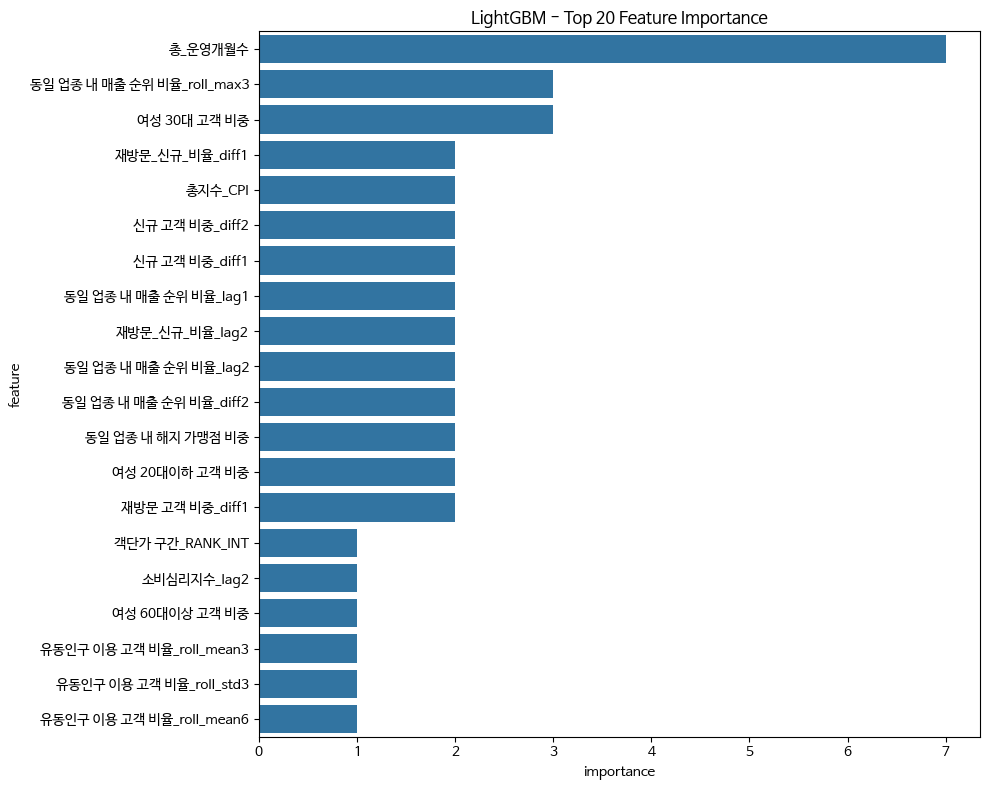


--- [LGBM] 모든 작업 완료 ---


In [ ]:
# =============================================================================
# 🚀 0단계: 라이브러리 임포트 및 기본 설정 (LightGBM 전용)
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (없으면 기본 폰트)
try:
    plt.rc('font', family='NanumBarunGothic')
except:
    print("나눔바른고딕 폰트가 설치되어 있지 않아, 기본 폰트로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False
print("--- [LGBM] 0단계 완료 ---")

# =============================================================================
# 🚀 1단계: 데이터 로드 및 통합
# =============================================================================
print("\n--- [LGBM] 1단계: 데이터 로드 및 통합 ---")
try:
    # df1_pre_org = pd.read_csv("df1_pre.csv")
    # df23_pre_org = pd.read_csv("df23_pre.csv")
    # out_pre_org = pd.read_csv("out_pre.csv")

    df1 = df1_pre_org.copy()
    df23 = df23_pre_org.copy()
    out  = out_pre_org.copy()
    print("✅ 데이터 로드 성공!")
except Exception as e:
    raise RuntimeError(f"❌ 파일 로드 실패: {e}")

df1['개설일']   = pd.to_datetime(df1['개설일'])
df23['기준년월'] = pd.to_datetime(df23['기준년월'])
out['기준년월']  = pd.to_datetime(out['기준년월'], format='%Y%m', errors='coerce')
df23.replace(-999999.9, np.nan, inplace=True)

df = pd.merge(df23, df1[['가맹점구분번호','업종','상권','개설일']], on='가맹점구분번호', how='left')
df = pd.merge(df, out, on='기준년월', how='left')
df = df.sort_values(['가맹점구분번호','기준년월']).reset_index(drop=True)
print(f"✅ 통합 완료! Shape: {df.shape}")

# =============================================================================
# 🚀 2단계: 타겟 정의 (3개월 후 위기)
# =============================================================================
print("\n--- [LGBM] 2단계: 타겟 정의 ---")
rank_col = '동일 업종 내 매출 순위 비율'
df_sorted = df.sort_values(['가맹점구분번호','기준년월']).copy()
df_sorted['rank_diff'] = df_sorted.groupby('가맹점구분번호')[rank_col].diff()

df['CRISIS'] = (
    (df_sorted['rank_diff'] > 30) |
    ((df_sorted[rank_col] > 80) & (df_sorted.groupby('가맹점구분번호')[rank_col].shift(1) <= 80))
).astype(int)
df['TARGET'] = df.groupby('가맹점구분번호')['CRISIS'].shift(-3)

print(f"✅ TARGET 생성! 'CRISIS' 합계: {int(df['CRISIS'].sum())}")

# =============================================================================
# 🚀 3단계: 시계열 피처 엔지니어링
# =============================================================================
print("\n--- [LGBM] 3단계: 시계열 피처 엔지니어링 ---")
df = df.sort_values(['가맹점구분번호','기준년월']).reset_index(drop=True)
df['총_운영개월수']   = ((df['기준년월'].dt.year - df['개설일'].dt.year) * 12 +
                      (df['기준년월'].dt.month - df['개설일'].dt.month))
df['재방문_신규_비율'] = df['재방문 고객 비중'] / (df['신규 고객 비중'] + 0.01)

feature_cols = [
    '동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율','재방문 고객 비중',
    '신규 고객 비중','거주 이용 고객 비율','직장 이용 고객 비율','유동인구 이용 고객 비율',
    '재방문_신규_비율','한국은행_기준금리','소비심리지수'
]
for col in feature_cols:
    print(f"  - {col}")
    for lag in [1,2,3,6]:
        df[f'{col}_lag{lag}']  = df.groupby('가맹점구분번호')[col].shift(lag)
        df[f'{col}_diff{lag}'] = df.groupby('가맹점구분번호')[col].diff(lag)
    for window in [3,6]:
        df[f'{col}_roll_mean{window}'] = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).mean())
        df[f'{col}_roll_std{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).std())
        df[f'{col}_roll_max{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).max())
print("✅ 피처 생성 완료")

# =============================================================================
# 🚀 4단계: 분할/전처리
# =============================================================================
print("\n--- [LGBM] 4단계: 데이터 분할 ---")
df_model = df.dropna(subset=['TARGET']).copy()
df_model.fillna(0, inplace=True)
df_model = pd.get_dummies(df_model, columns=['업종','상권'], dummy_na=False)

train_end, val_end = '2024-03-31', '2024-06-30'
train_df = df_model[df_model['기준년월'] <= train_end]
val_df   = df_model[(df_model['기준년월'] > train_end) & (df_model['기준년월'] <= val_end)]
test_df  = df_model[df_model['기준년월'] > val_end]

drop_cols = ['가맹점구분번호','기준년월','개설일','CRISIS','TARGET']
features  = [c for c in df_model.columns if c not in drop_cols]

X_train, y_train = train_df[features], train_df['TARGET'].astype(int)
X_val,   y_val   = val_df[features],   val_df['TARGET'].astype(int)
X_test,  y_test  = test_df[features],  test_df['TARGET'].astype(int)

print(f"✅ 분할 완료 | Train {X_train.shape} | Val {X_val.shape} | Test {X_test.shape}")

# =============================================================================
# 🚀 5단계: LightGBM 학습/평가
# =============================================================================
print("\n--- [LGBM] 5단계: 모델 학습/평가 ---")
lgbm = lgb.LGBMClassifier(
    random_state=42, is_unbalance=True, n_jobs=-1,
    n_estimators=1000, learning_rate=0.05,
    num_leaves=63, subsample=0.8, colsample_bytree=0.8
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
y_pred       = lgbm.predict(X_test)

roc_auc  = roc_auc_score(y_test, y_pred_proba)
prec     = precision_score(y_test, y_pred, zero_division=0)
rec      = recall_score(y_test, y_pred, zero_division=0)
f1       = f1_score(y_test, y_pred, zero_division=0)

print(f"✅ 성능 | ROC-AUC: {roc_auc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

# =============================================================================
# 🚀 6단계: 피처 중요도
# =============================================================================
print("\n--- [LGBM] 6단계: 피처 중요도 ---")
fi = pd.DataFrame({
    'feature': features,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=fi)
plt.title('LightGBM - Top 20 Feature Importance')
plt.tight_layout()
plt.show()

print("\n--- [LGBM] 모든 작업 완료 ---")


--- 0단계: 라이브러리 및 설정 완료 ---

--- STAGE 1: 월별 위기 점수(Crisis Score) 생성 시작 ---

--- [위기모델] 1단계: 데이터 로드 및 통합 ---
✅ 데이터 로드 성공!
✅ 통합 완료! Shape: (86590, 74)

--- [위기모델] 2&3단계: 타겟 정의 및 피처 엔지니어링 ---
✅ 피처 생성 완료

--- [위기모델] 4&5단계: 위기 예측 모델 훈련 ---
✅ 위기 예측 모델 훈련 완료!
✅ 월별 위기 점수 생성 완료!

--- STAGE 2: 최종 폐업 예측 시작 ---

--- [폐업모델] 1단계: 위기 점수 피처화 ---
✅ 최종 폐업 예측 데이터셋 생성 완료!

--- [폐업모델] 2단계: 최종 폐업 예측 모델 훈련 및 평가 ---
--- Fold 1 훈련 ---
--- Fold 2 훈련 ---
--- Fold 3 훈련 ---
--- Fold 4 훈련 ---
--- Fold 5 훈련 ---


--- 📊 최종 폐업 예측 모델 성능 (5-Fold CV) ---
  - ROC-AUC: 0.4718
  - 최적 임계값: 0.1047
  - 최종 Precision: 0.0354
  - 최종 Recall: 0.1134
  - 최종 F1-Score: 0.0539

--- [폐업모델] 3단계: 피처 중요도 시각화 ---


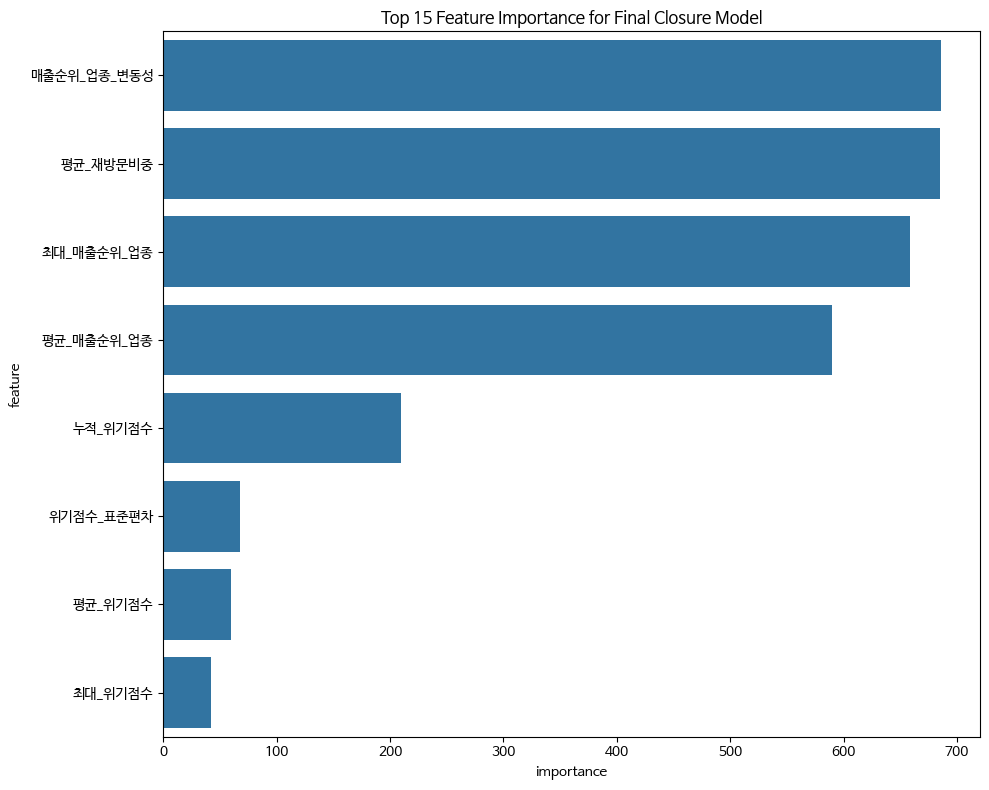


--- 모든 작업 완료 ---


In [ ]:
# = a============================================================================
# 🚀 0단계: 라이브러리 임포트 및 기본 설정
# ==============================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정
try:
    plt.rc('font', family='NanumBarunGothic')
except:
    print("나눔바른고딕 폰트가 설치되어 있지 않아, 기본 폰트로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False
print("--- 0단계: 라이브러리 및 설정 완료 ---")

# ==============================================================================
# 🚀 STAGE 1: 시계열 모델 재현으로 "월별 위기 점수" 생성
# ==============================================================================
print("\n--- STAGE 1: 월별 위기 점수(Crisis Score) 생성 시작 ---")

# 1-1. 데이터 로드 및 통합 (사용자 제공 코드 기반)
print("\n--- [위기모델] 1단계: 데이터 로드 및 통합 ---")
try:
    # df1_pre_org = pd.read_csv("df1_pre.csv")
    # df23_pre_org = pd.read_csv("df23_pre.csv")
    # out_pre_org = pd.read_csv("out_pre.csv")

    df1 = df1_pre_org.copy()
    df23 = df23_pre_org.copy()
    out  = out_pre_org.copy()
    print("✅ 데이터 로드 성공!")
except Exception as e:
    raise RuntimeError(f"❌ 파일 로드 실패: {e}")

df1['개설일']  = pd.to_datetime(df1['개설일'])
df23['기준년월'] = pd.to_datetime(df23['기준년월'])
out['기준년월']  = pd.to_datetime(out['기준년월'], format='%Y%m', errors='coerce')
df23.replace(-999999.9, np.nan, inplace=True)

df = pd.merge(df23, df1[['가맹점구분번호','업종','상권','개설일']], on='가맹점구분번호', how='left')
df = pd.merge(df, out, on='기준년월', how='left')
df = df.sort_values(['가맹점구분번호','기준년월']).reset_index(drop=True)
print(f"✅ 통합 완료! Shape: {df.shape}")


# 1-2. Y값 및 피처 엔지니어링 (사용자 제공 코드 기반)
print("\n--- [위기모델] 2&3단계: 타겟 정의 및 피처 엔지니어링 ---")
rank_col = '동일 업종 내 매출 순위 비율'
df_sorted = df.sort_values(['가맹점구분번호','기준년월']).copy()
df_sorted['rank_diff'] = df_sorted.groupby('가맹점구분번호')[rank_col].diff()
df['CRISIS'] = ((df_sorted['rank_diff'] > 30) | ((df_sorted[rank_col] > 80) & (df_sorted.groupby('가맹점구분번호')[rank_col].shift(1) <= 80))).astype(int)
df['TARGET'] = df.groupby('가맹점구분번호')['CRISIS'].shift(-3)
df['총_운영개월수']  = ((df['기준년월'].dt.year - df['개설일'].dt.year) * 12 + (df['기준년월'].dt.month - df['개설일'].dt.month))
df['재방문_신규_비율'] = df['재방문 고객 비중'] / (df['신규 고객 비중'] + 0.01)
feature_cols = ['동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율','재방문 고객 비중', '신규 고객 비중',
                '거주 이용 고객 비율','직장 이용 고객 비율','유동인구 이용 고객 비율', '재방문_신규_비율',
                '한국은행_기준금리','소비심리지수']
for col in feature_cols:
    for lag in [1,2,3,6]:
        df[f'{col}_lag{lag}']  = df.groupby('가맹점구분번호')[col].shift(lag)
        df[f'{col}_diff{lag}'] = df.groupby('가맹점구분번호')[col].diff(lag)
    for window in [3,6]:
        df[f'{col}_roll_mean{window}'] = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).mean())
        df[f'{col}_roll_std{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).std())
        df[f'{col}_roll_max{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).max())
print("✅ 피처 생성 완료")

# 1-3. 시계열 모델 훈련 (사용자 제공 코드 기반)
print("\n--- [위기모델] 4&5단계: 위기 예측 모델 훈련 ---")
df_model = df.dropna(subset=['TARGET']).copy()
df_model.fillna(0, inplace=True)
df_model_dummies = pd.get_dummies(df_model, columns=['업종','상권'], dummy_na=False)
train_end, val_end = '2024-03-31', '2024-06-30'
train_df = df_model_dummies[df_model_dummies['기준년월'] <= train_end]
val_df   = df_model_dummies[(df_model_dummies['기준년월'] > train_end) & (df_model_dummies['기준년월'] <= val_end)]
drop_cols = ['가맹점구분번호','기준년월','개설일','CRISIS','TARGET']
features  = [c for c in df_model_dummies.columns if c not in drop_cols]
X_train, y_train = train_df[features], train_df['TARGET'].astype(int)
X_val,   y_val   = val_df[features],   val_df['TARGET'].astype(int)

ts_model = lgb.LGBMClassifier(random_state=42, is_unbalance=True, n_jobs=-1, n_estimators=1000,
                              learning_rate=0.05, num_leaves=63, subsample=0.8, colsample_bytree=0.8)
ts_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc',
             callbacks=[lgb.early_stopping(50, verbose=False)])
print("✅ 위기 예측 모델 훈련 완료!")

# 1-4. 전체 기간에 대한 "위기 점수" 예측
full_features_dummies = pd.get_dummies(df.fillna(0), columns=['업종', '상권'], dummy_na=False)
train_cols = X_train.columns
for col in train_cols:
    if col not in full_features_dummies.columns:
        full_features_dummies[col] = 0
full_features_dummies = full_features_dummies[train_cols]

crisis_scores_proba = ts_model.predict_proba(full_features_dummies)[:, 1]
df['CRISIS_SCORE'] = crisis_scores_proba
print("✅ 월별 위기 점수 생성 완료!")

# ==============================================================================
# 🚀 STAGE 2: "위기 점수" 피처를 활용한 최종 폐업 예측
# ==============================================================================
print("\n--- STAGE 2: 최종 폐업 예측 시작 ---")

# 2-1. 위기 점수 피처 생성
print("\n--- [폐업모델] 1단계: 위기 점수 피처화 ---")
crisis_features = df.groupby('가맹점구분번호')['CRISIS_SCORE'].agg(['mean', 'max', 'std', 'sum']).reset_index()
crisis_features.columns = ['가맹점구분번호', '평균_위기점수', '최대_위기점수', '위기점수_표준편차', '누적_위기점수']

# 2-2. 기본 정적 피처 생성
static_features = df.groupby('가맹점구분번호').agg(
    평균_매출순위_업종=('동일 업종 내 매출 순위 비율', 'mean'),
    최대_매출순위_업종=('동일 업종 내 매출 순위 비율', 'max'),
    매출순위_업종_변동성=('동일 업종 내 매출 순위 비율', 'std'),
    평균_재방문비중=('재방문 고객 비중', 'mean')
).reset_index()

# 2-3. 폐업 여부(Y) 데이터 준비
df1_pre_org['폐업일'] = pd.to_datetime(df1_pre_org['폐업일'])
df1_pre_org['폐업년도'] = df1_pre_org['폐업일'].dt.year
analysis_base = df1_pre_org[(df1_pre_org['폐업년도'].isna()) | (df1_pre_org['폐업년도'] == 2025)].copy()
analysis_base['TARGET_CLOSURE'] = (analysis_base['폐업년도'] == 2025).astype(int)

# 2-4. 모든 피처와 Y값 결합
final_df = pd.merge(analysis_base[['가맹점구분번호', 'TARGET_CLOSURE']], static_features, on='가맹점구분번호', how='left')
final_df = pd.merge(final_df, crisis_features, on='가맹점구분번호', how='left')
final_df.fillna(0, inplace=True)
print("✅ 최종 폐업 예측 데이터셋 생성 완료!")

# ==============================================================================
# 🚀 3단계: 최종 폐업 예측 모델 훈련 및 평가
# ==============================================================================
print("\n--- [폐업모델] 2단계: 최종 폐업 예측 모델 훈련 및 평가 ---")
X = final_df.drop(columns=['가맹점구분번호', 'TARGET_CLOSURE'])
y = final_df['TARGET_CLOSURE']

# 계층화 K-Fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_model = lgb.LGBMClassifier(random_state=42, is_unbalance=True, n_jobs=-1)
oof_preds = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1} 훈련 ---")
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
    final_model.fit(X_train_fold, y_train_fold)
    oof_preds[val_idx] = final_model.predict_proba(X_val_fold)[:, 1]

# 최종 성능 평가
roc_auc = roc_auc_score(y, oof_preds)
precisions, recalls, thresholds = precision_recall_curve(y, oof_preds)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_best = (oof_preds > best_threshold).astype(int)
precision_best = precision_score(y, y_pred_best)
recall_best = recall_score(y, y_pred_best)
f1_best = f1_score(y, y_pred_best)

print("\n\n--- 📊 최종 폐업 예측 모델 성능 (5-Fold CV) ---")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - 최적 임계값: {best_threshold:.4f}")
print(f"  - 최종 Precision: {precision_best:.4f}")
print(f"  - 최종 Recall: {recall_best:.4f}")
print(f"  - 최종 F1-Score: {f1_best:.4f}")

# 피처 중요도 시각화 (마지막 Fold 모델 기준)
print("\n--- [폐업모델] 3단계: 피처 중요도 시각화 ---")
plt.figure(figsize=(10, 8))
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 15 Feature Importance for Final Closure Model')
plt.tight_layout()
plt.show()

print("\n--- 모든 작업 완료 ---")



--- 0단계: 라이브러리 및 설정 완료 ---

--- STAGE 1: 월별 위기 점수(Crisis Score) 생성 시작 ---

--- [위기모델] 1단계: 데이터 로드 및 통합 ---
✅ 데이터 로드 성공!
✅ 통합 완료! Shape: (86590, 74)

--- [위기모델] 2&3단계: 타겟 정의 및 피처 엔지니어링 ---
✅ 피처 생성 완료

--- [위기모델] 4&5단계: 위기 예측 모델 훈련 ---
✅ 위기 예측 모델 훈련 완료!
✅ 월별 위기 점수 생성 완료!

--- STAGE 2 (컷오프 기반): 최종 폐업 예측 시작 ---

--- [폐업모델] 1단계: 기준시점 이전 최근 6개월 위기점수 요약 ---

--- [폐업모델] 2단계: 라벨링 ---
데이터셋: (3880, 104), 양성 비율: 0.0041
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
--- Fold 5 ---


--- 📊 컷오프 기반 최종 폐업 예측 성능 (Group 5-Fold) ---
ROC-AUC : 0.5206
PR-AUC  : 0.0045
Best thr: 0.0039
Precision: 0.0060 | Recall: 0.1250 | F1: 0.0115


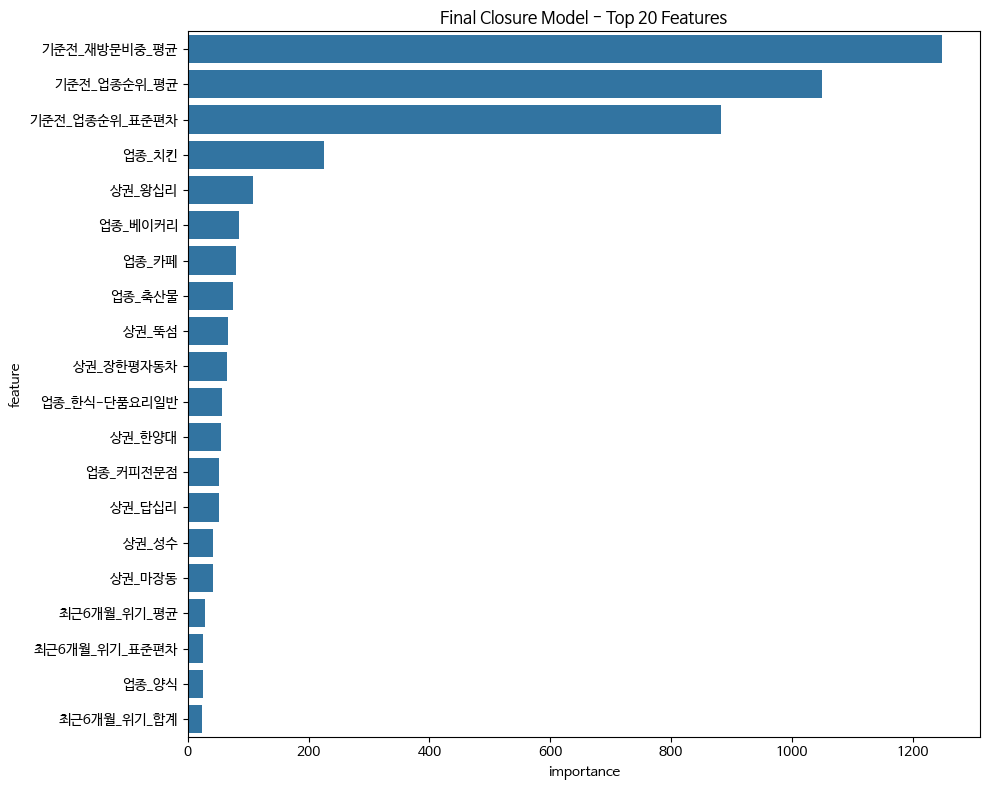


--- 모든 작업 완료 ---


In [ ]:
# =============================================================================
# 🚀 0단계: 라이브러리 임포트 및 기본 설정
# =============================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)

warnings.filterwarnings('ignore')

# 한글 폰트 설정
try:
    plt.rc('font', family='NanumBarunGothic')
except:
    print("나눔바른고딕 폰트가 설치되어 있지 않아, 기본 폰트로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False
print("--- 0단계: 라이브러리 및 설정 완료 ---")


# =============================================================================
# 🚀 STAGE 1: 시계열 모델로 "월별 위기 점수(CRISIS_SCORE)" 생성
# =============================================================================
print("\n--- STAGE 1: 월별 위기 점수(Crisis Score) 생성 시작 ---")

# 1-1. 데이터 로드 & 통합 (세션 변수 우선, 없으면 CSV 로드)
print("\n--- [위기모델] 1단계: 데이터 로드 및 통합 ---")
def _maybe_var(name):
    return name in globals() and globals()[name] is not None

try:
    if _maybe_var('df1_pre_org') and _maybe_var('df23_pre_org') and _maybe_var('out_pre_org'):
        df1_pre = df1_pre_org.copy()
        df23_pre = df23_pre_org.copy()
        out_pre  = out_pre_org.copy()
    else:
        df1_pre = pd.read_csv("df1_pre.csv")
        df23_pre = pd.read_csv("df23_pre.csv")
        out_pre  = pd.read_csv("out_pre.csv")
    print("✅ 데이터 로드 성공!")
except Exception as e:
    raise RuntimeError(f"❌ 파일 로드 실패: {e}")

# 원본 보존
df1 = df1_pre.copy()
df23 = df23_pre.copy()
out  = out_pre.copy()

# 형 변환
df1['개설일']   = pd.to_datetime(df1['개설일'])
if '폐업일' in df1.columns:
    df1['폐업일'] = pd.to_datetime(df1['폐업일'], errors='coerce')
df23['기준년월'] = pd.to_datetime(df23['기준년월'])
out['기준년월']  = pd.to_datetime(out['기준년월'], format='%Y%m', errors='coerce')
df23.replace(-999999.9, np.nan, inplace=True)

# 병합
df = pd.merge(df23, df1[['가맹점구분번호','업종','상권','개설일']], on='가맹점구분번호', how='left')
df = pd.merge(df, out, on='기준년월', how='left')
df = df.sort_values(['가맹점구분번호','기준년월']).reset_index(drop=True)
print(f"✅ 통합 완료! Shape: {df.shape}")

# 1-2. 타겟 정의 & 피처 엔지니어링
print("\n--- [위기모델] 2&3단계: 타겟 정의 및 피처 엔지니어링 ---")
rank_col = '동일 업종 내 매출 순위 비율'
df_sorted = df.sort_values(['가맹점구분번호','기준년월']).copy()
df_sorted['rank_diff'] = df_sorted.groupby('가맹점구분번호')[rank_col].diff()

df['CRISIS'] = (
    (df_sorted['rank_diff'] > 30) |
    ((df_sorted[rank_col] > 80) &
     (df_sorted.groupby('가맹점구분번호')[rank_col].shift(1) <= 80))
).astype(int)

# 3개월 후 위기 발생 레이블
df['TARGET'] = df.groupby('가맹점구분번호')['CRISIS'].shift(-3)

# 시계열 파생
df['총_운영개월수']   = ((df['기준년월'].dt.year - df['개설일'].dt.year) * 12 +
                      (df['기준년월'].dt.month - df['개설일'].dt.month))
df['재방문_신규_비율'] = df['재방문 고객 비중'] / (df['신규 고객 비중'] + 0.01)

feature_cols = [
    '동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율','재방문 고객 비중',
    '신규 고객 비중','거주 이용 고객 비율','직장 이용 고객 비율','유동인구 이용 고객 비율',
    '재방문_신규_비율','한국은행_기준금리','소비심리지수'
]
for col in feature_cols:
    for lag in [1,2,3,6]:
        df[f'{col}_lag{lag}']  = df.groupby('가맹점구분번호')[col].shift(lag)
        df[f'{col}_diff{lag}'] = df.groupby('가맹점구분번호')[col].diff(lag)
    for window in [3,6]:
        df[f'{col}_roll_mean{window}'] = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).mean())
        df[f'{col}_roll_std{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).std())
        df[f'{col}_roll_max{window}']  = df.groupby('가맹점구분번호')[col].transform(lambda x: x.rolling(window).max())
print("✅ 피처 생성 완료")

# 1-3. 시계열 모델 훈련 (train: ~2024-03, val: 2024-04~06)
print("\n--- [위기모델] 4&5단계: 위기 예측 모델 훈련 ---")
df_model = df.dropna(subset=['TARGET']).copy()
df_model.fillna(0, inplace=True)
df_model_dummies = pd.get_dummies(df_model, columns=['업종','상권'], dummy_na=False)

train_end, val_end = '2024-03-31', '2024-06-30'
train_df = df_model_dummies[df_model_dummies['기준년월'] <= train_end]
val_df   = df_model_dummies[(df_model_dummies['기준년월'] > train_end) & (df_model_dummies['기준년월'] <= val_end)]

drop_cols = ['가맹점구분번호','기준년월','개설일','CRISIS','TARGET']
features  = [c for c in df_model_dummies.columns if c not in drop_cols]

X_train, y_train = train_df[features], train_df['TARGET'].astype(int)
X_val,   y_val   = val_df[features],   val_df['TARGET'].astype(int)

ts_model = lgb.LGBMClassifier(
    random_state=42, is_unbalance=True, n_jobs=-1,
    n_estimators=1000, learning_rate=0.05,
    num_leaves=63, subsample=0.8, colsample_bytree=0.8
)
ts_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
print("✅ 위기 예측 모델 훈련 완료!")

# 1-4. 전체 기간 월별 "CRISIS_SCORE" 생성
full_features = pd.get_dummies(df.fillna(0), columns=['업종','상권'], dummy_na=False)
# 훈련 시 사용된 컬럼과 정렬 일치
for col in X_train.columns:
    if col not in full_features.columns:
        full_features[col] = 0
full_features = full_features[X_train.columns]

df['CRISIS_SCORE'] = ts_model.predict_proba(full_features)[:, 1]
print("✅ 월별 위기 점수 생성 완료!")


# =============================================================================
# 🚀 STAGE 2: 컷오프 기반 "최종 폐업 예측" (12개월 이내)
# =============================================================================
print("\n--- STAGE 2 (컷오프 기반): 최종 폐업 예측 시작 ---")

# 2-0. 컷오프/호라이즌 파라미터
cutoff_date = pd.Timestamp('2024-06-30')
horizon_months = 12
horizon_start = cutoff_date + pd.offsets.Day(1)
horizon_end   = cutoff_date + pd.offsets.MonthEnd(horizon_months)

# 2-1. 기준시점 이전 최근 6개월 위기점수 요약
print("\n--- [폐업모델] 1단계: 기준시점 이전 최근 6개월 위기점수 요약 ---")
df_cut = df[df['기준년월'] <= cutoff_date].copy()
recent_start = cutoff_date - pd.offsets.MonthEnd(5)   # cutoff 포함 최근 6개월
recent_win = df_cut[(df_cut['기준년월'] >= recent_start) & (df_cut['기준년월'] <= cutoff_date)]

crisis_agg = recent_win.groupby('가맹점구분번호')['CRISIS_SCORE'].agg(
    최근6개월_위기_평균='mean',
    최근6개월_위기_최대='max',
    최근6개월_위기_표준편차='std',
    최근6개월_위기_합계='sum',
).reset_index().fillna(0)

# 기준시점 이전 장기 통계(선택)
base_agg = df_cut.groupby('가맹점구분번호').agg(
    기준전_업종순위_평균=('동일 업종 내 매출 순위 비율', 'mean'),
    기준전_업종순위_표준편차=('동일 업종 내 매출 순위 비율', 'std'),
    기준전_재방문비중_평균=('재방문 고객 비중', 'mean'),
).reset_index().fillna(0)

# 2-2. 라벨링: 기준시점에 영업 중 & 이후 12개월 내 폐업 여부
print("\n--- [폐업모델] 2단계: 라벨링 ---")
df1_lbl = df1.copy()
if '폐업일' not in df1_lbl.columns:
    df1_lbl['폐업일'] = pd.NaT
df1_lbl['개설일'] = pd.to_datetime(df1_lbl['개설일'])
df1_lbl['폐업일'] = pd.to_datetime(df1_lbl['폐업일'], errors='coerce')

alive_at_cutoff = df1_lbl[
    (df1_lbl['개설일'] <= cutoff_date) &
    (df1_lbl['폐업일'].isna() | (df1_lbl['폐업일'] > cutoff_date))
].copy()

alive_at_cutoff['TARGET_CLOSURE'] = (
    alive_at_cutoff['폐업일'].between(horizon_start, horizon_end, inclusive='both')
).astype(int)

# 2-3. 피처 결합 (+ 기준시점 직전 업종/상권 더미)
latest_before_cut = (
    df_cut.sort_values(['가맹점구분번호','기준년월'])
          .groupby('가맹점구분번호')
          .tail(1)[['가맹점구분번호','업종','상권']]
)
latest_onehot = pd.get_dummies(latest_before_cut, columns=['업종','상권'], dummy_na=False)

final_df = alive_at_cutoff[['가맹점구분번호','TARGET_CLOSURE']] \
    .merge(crisis_agg, on='가맹점구분번호', how='left') \
    .merge(base_agg, on='가맹점구분번호', how='left') \
    .merge(latest_onehot, on='가맹점구분번호', how='left') \
    .fillna(0)

X = final_df.drop(columns=['가맹점구분번호','TARGET_CLOSURE'])
y = final_df['TARGET_CLOSURE'].astype(int)
groups = final_df['가맹점구분번호']  # 그룹 분할용

print(f"데이터셋: {final_df.shape}, 양성 비율: {y.mean():.4f}")

# 2-4. Group Stratified K-Fold (가맹점 단위로 분할)
try:
    from sklearn.model_selection import StratifiedGroupKFold
    gskf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = gskf.split(X, y, groups=groups)
except Exception:
    from sklearn.model_selection import GroupKFold
    print("[경고] StratifiedGroupKFold 미지원 → GroupKFold로 대체 (라벨 불균형 주의)")
    gkf = GroupKFold(n_splits=5)
    # GroupKFold는 strata 보장이 없으므로 바로 사용
    split_iter = gkf.split(X, groups=groups)

# 2-5. 모델 학습 & OOF 예측
clf = lgb.LGBMClassifier(
    random_state=42, is_unbalance=True, n_jobs=-1,
    n_estimators=1000, learning_rate=0.05,
    num_leaves=63, subsample=0.8, colsample_bytree=0.8
)

oof = np.zeros(len(X))
for fold, (tr_idx, va_idx) in enumerate(split_iter):
    print(f"--- Fold {fold+1} ---")
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    oof[va_idx] = clf.predict_proba(X_va)[:, 1]

# 2-6. 최종 성능 (ROC-AUC, PR-AUC, F1 최적 임계값)
roc = roc_auc_score(y, oof)
ap  = average_precision_score(y, oof)  # PR-AUC
precisions, recalls, thresholds = precision_recall_curve(y, oof)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_i = np.nanargmax(f1s)
best_thr = thresholds[max(0, best_i-1)] if best_i < len(thresholds) else 0.5

y_hat = (oof >= best_thr).astype(int)
p = precision_score(y, y_hat, zero_division=0)
r = recall_score(y, y_hat, zero_division=0)
f1 = f1_score(y, y_hat, zero_division=0)

print("\n\n--- 📊 컷오프 기반 최종 폐업 예측 성능 (Group 5-Fold) ---")
print(f"ROC-AUC : {roc:.4f}")
print(f"PR-AUC  : {ap:.4f}")
print(f"Best thr: {best_thr:.4f}")
print(f"Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")

# 2-7. 중요도 Top 20
fi = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}) \
        .sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=fi)
plt.title('Final Closure Model - Top 20 Features')
plt.tight_layout()
plt.show()

print("\n--- 모든 작업 완료 ---")
